In [1]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm
import warnings

from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, accuracy_score, homogeneity_score, silhouette_score, classification_report

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
SEED=2023

df1 = pd.read_csv('electricity-normalized.csv')
df1['class'] = df1['class'].apply(lambda x: 1 if x=='UP' else 0)
df2 = pd.read_csv('wine.csv')
df1_X = df1[['period', 'nswprice', 'nswdemand', 'vicprice',
       'vicdemand', 'transfer']]
df1_y = df1['class']

df2_X = df2[['Alcohol', 'Malic_acid', 'Ash', 'Alcalinity_of_ash',
       'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols',
       'Proanthocyanins', 'Color_intensity', 'Hue', 'Od_Hod_of_diluted_wines',
       'Proline']]
df2_y = df2['class']

min_max_scaler = MinMaxScaler()

df1_X = min_max_scaler.fit_transform(df1_X)
df2_X = min_max_scaler.fit_transform(df2_X)

In [3]:
%%time

cv1 = SelectFromModel(LassoCV(max_iter=10000), max_features=df1_X.shape[1])
cv1.fit(df1_X, df1_y)
ica_result1 = cv1.transform(df1_X)
print(df1_X.shape[1], ica_result1.shape[1])


6 3
CPU times: user 3.36 s, sys: 485 ms, total: 3.85 s
Wall time: 3.23 s


In [4]:
%%time

cv2 = SelectFromModel(LassoCV(max_iter=10000), max_features=df2_X.shape[1])
cv2.fit(df2_X, df2_y)
ica_result2 = cv2.transform(df2_X)
print(df2_X.shape[1], ica_result2.shape[1])


13 13
CPU times: user 185 ms, sys: 69.7 ms, total: 255 ms
Wall time: 70.3 ms


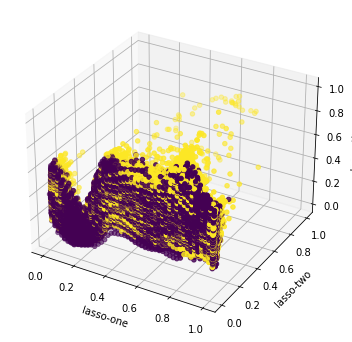

In [5]:
ax = plt.figure(figsize=(10,6)).add_subplot(projection='3d')
ax.scatter(
    xs=ica_result1[:, 0], 
    ys=ica_result1[:, 1], 
    zs=ica_result1[:, 2], 
    c=df1_y.values
)
ax.set_xlabel('lasso-one')
ax.set_ylabel('lasso-two')
ax.set_zlabel('lasso-three')
plt.show()

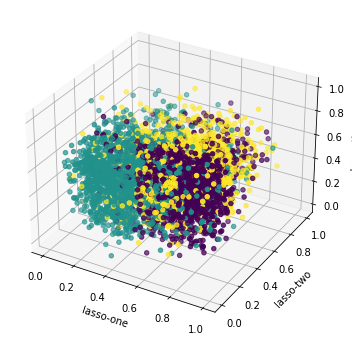

In [6]:
ax = plt.figure(figsize=(10,6)).add_subplot(projection='3d')
ax.scatter(
    xs=ica_result2[:, 0], 
    ys=ica_result2[:, 1], 
    zs=ica_result2[:, 2], 
    c=df2_y.values
)
ax.set_xlabel('lasso-one')
ax.set_ylabel('lasso-two')
ax.set_zlabel('lasso-three')
plt.show()

# K Means

100%|██████████| 18/18 [08:42<00:00, 29.04s/it]


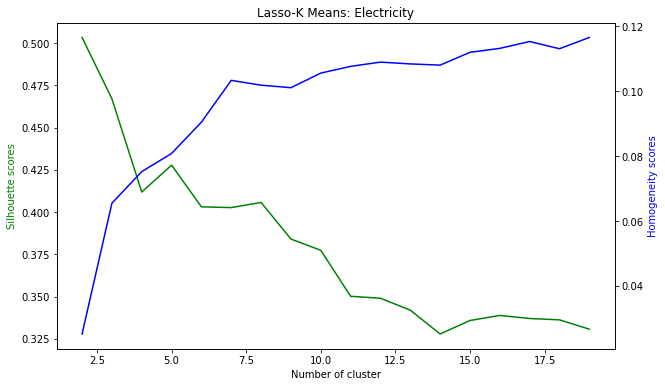

In [7]:
X = ica_result1.copy()
y = df1_y.copy()

clusters = np.arange(2, 20)
silh_scores = []
homog_scores = []
for cluster in tqdm(clusters):
    kmeans = KMeans(n_clusters=cluster, max_iter=1000, n_init=5, random_state=SEED).fit(X)
    pred = kmeans.predict(X)
    silh_scores.append(silhouette_score(X, pred, metric='euclidean'))
    homog_scores.append(homogeneity_score(y, pred))

fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()
ax1.plot(clusters, silh_scores, 'g-')
ax2.plot(clusters, homog_scores, 'b-')

ax1.set_xlabel('Number of cluster')
ax1.set_ylabel('Silhouette scores', color='g')
ax2.set_ylabel('Homogeneity scores', color='b')
plt.title('Lasso-K Means: Electricity')

plt.show()


100%|██████████| 18/18 [00:09<00:00,  2.00it/s]


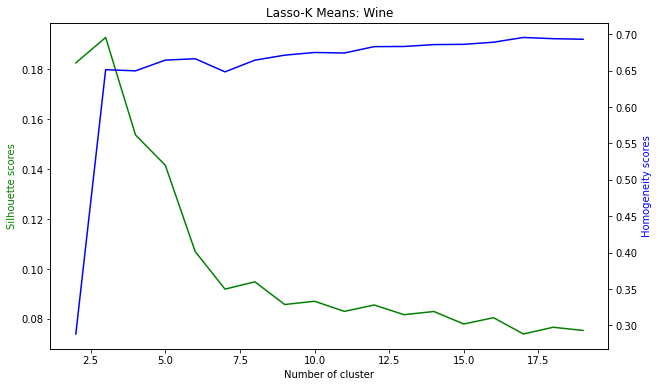

In [8]:
X = ica_result2.copy()
y = df2_y.copy()

clusters = np.arange(2, 20)
silh_scores = []
homog_scores = []
for cluster in tqdm(clusters):
    kmeans = KMeans(n_clusters=cluster, max_iter=1000, n_init=5, random_state=SEED).fit(X)
    pred = kmeans.predict(X)
    silh_scores.append(silhouette_score(X, pred, metric='euclidean'))
    homog_scores.append(homogeneity_score(y, pred))

fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()
ax1.plot(clusters, silh_scores, 'g-')
ax2.plot(clusters, homog_scores, 'b-')

ax1.set_xlabel('Number of cluster')
ax1.set_ylabel('Silhouette scores', color='g')
ax2.set_ylabel('Homogeneity scores', color='b')
plt.title('Lasso-K Means: Wine')

plt.show()


# EM

100%|██████████| 18/18 [09:30<00:00, 31.69s/it]


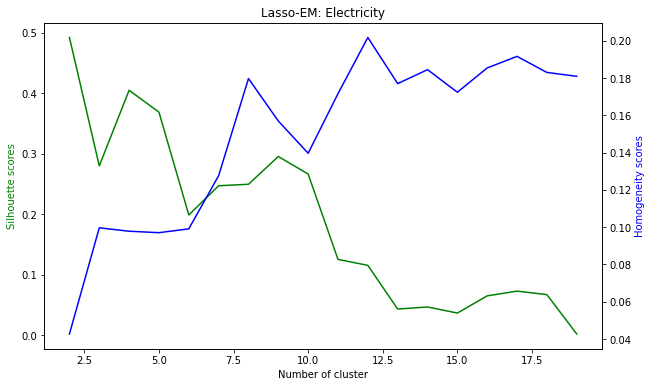

In [9]:
X = ica_result1.copy()
y = df1_y.copy()

clusters = np.arange(2, 20)

silh_scores = []
homog_scores = []

for cluster in tqdm(clusters):
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=SEED, 
                          n_init=5).fit(X)
    label = gmm.predict(X)
    silh_scores.append(silhouette_score(X, label, metric='euclidean'))
    homog_scores.append(homogeneity_score(y, label))

    
fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()
ax1.plot(clusters, silh_scores, 'g-')
ax2.plot(clusters, homog_scores, 'b-')

ax1.set_xlabel('Number of cluster')
ax1.set_ylabel('Silhouette scores', color='g')
ax2.set_ylabel('Homogeneity scores', color='b')
plt.title('Lasso-EM: Electricity')

plt.show()

100%|██████████| 18/18 [00:44<00:00,  2.46s/it]


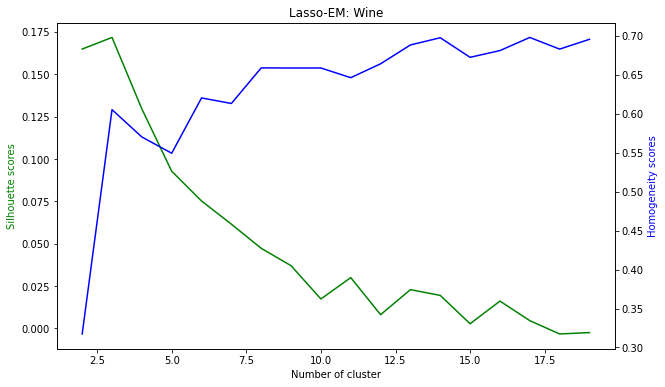

In [10]:
X = ica_result2.copy()
y = df2_y.copy()

clusters = np.arange(2, 20)

silh_scores = []
homog_scores = []

for cluster in tqdm(clusters):
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=SEED, 
                          n_init=5).fit(X)
    label = gmm.predict(X)
    silh_scores.append(silhouette_score(X, label, metric='euclidean'))
    homog_scores.append(homogeneity_score(y, label))

    
fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()
ax1.plot(clusters, silh_scores, 'g-')
ax2.plot(clusters, homog_scores, 'b-')

ax1.set_xlabel('Number of cluster')
ax1.set_ylabel('Silhouette scores', color='g')
ax2.set_ylabel('Homogeneity scores', color='b')
plt.title('Lasso-EM: Wine')

plt.show()

# NN

In [20]:
X_train, X_test, y_train, y_test = train_test_split(ica_result2, 
                                                    df2_y, 
                                                    test_size=0.33, 
                                                    random_state=SEED,
                                                    stratify=df2_y)


In [21]:
param_grid = {
    'hidden_layer_sizes': [(16,16), (16,32), (32, 32)],
    "alpha" : [0.1, 0.01, 0.001]
}
cv = GridSearchCV(MLPClassifier(), param_grid, cv=10, 
                         scoring='f1_weighted', n_jobs=-2)
cv.fit(X_train, y_train)

print(cv.best_estimator_)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(16, 32))


In [22]:
nn = MLPClassifier(alpha=cv.best_estimator_.alpha, hidden_layer_sizes=cv.best_estimator_.hidden_layer_sizes)
nn.fit(X_train, y_train)

pred = nn.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.91      0.93      0.92       521
           2       0.93      0.90      0.91       664
           3       0.90      0.93      0.92       465

    accuracy                           0.92      1650
   macro avg       0.91      0.92      0.92      1650
weighted avg       0.92      0.92      0.92      1650

